In [8]:
import numpy as np
import torch
import cv2
import os
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

In [9]:
DataPath = "flower_images"
dic = {'Lilly': 0, 'Lotus': 1, 'Orchid': 2, 'Sunflower': 3, 'Tulip': 4}

image_path = []
image_labels = []

for name, label in dic.items():
  path = os.path.join(DataPath, name)
  for f in os.listdir(path):
    image_path.append(os.path.join(name, f))
    image_labels.append(label)

In [10]:
class FlowersDataset(Dataset):
    def __init__(self, file_list, file_label, dir, transform=None):
        self.file_list = file_list
        self.file_label = file_label
        self.dir = dir
        self.transform = transform

            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        #считываем изображение
        image = cv2.imread(os.path.join(self.dir, self.file_list[idx]))
        #делаем изображение RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #присваиваем лейбл каждой картинке
        self.label = self.file_label[idx]
        image = self.transform(image)
        
        return image, float(self.label)

In [11]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
])
data = FlowersDataset(image_path, image_labels, DataPath, transform)
train_size = int(len(data) * 0.2)
train_set, test_set = torch.utils.data.random_split(data, (len(data) - train_size, train_size))
trainloader = torch.utils.data.DataLoader(train_set, pin_memory=True, 
                                        batch_size = 32, shuffle=True, num_workers=0)

testloader = torch.utils.data.DataLoader(test_set, batch_size = 32, num_workers=0)
device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = nn.CrossEntropyLoss()
epoch = 10

In [17]:
def train(model, dataloader, criterion, optimizer, epochs, device):
    model.train()
    train_losses = []
    train_accuracy = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        correct = 0
        total = 0
        
        for _, (data, target) in tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{epochs}"):
            data = data.to(device)
            target = target.type(torch.LongTensor).to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            # Подсчет точности
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        
        epoch_loss /= len(dataloader)
        train_losses.append(epoch_loss)
        accuracy = 100 * correct / total
        train_accuracy.append(accuracy)
        
        print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return (train_losses, train_accuracy)

def validate(model, testloader, device):
    total = 0
    correct = 0
    all_labels = []
    all_predictions = []

    # Зададим параметры, чтобы модель не считала градиенты
    with torch.no_grad():
        # переводим модель в режим "оценивания"
        model.eval()
        for images, labels in testloader:
            # прогоняем изображения через модель
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # получим максимальное значение (это и будет наш лейбл)
            predicted = torch.max(outputs.data, 1)[1]
            # Посчитаем количество лейблов
            total += len(labels)
            # Посчитаем количество правильных предиктов
            correct += (predicted == labels).sum()

            # Сохраним все лейблы и предсказания для дальнейшего анализа
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / float(total)
    print('Accuracy: {:.2f} %'.format(accuracy))

    # Преобразуем списки в numpy массивы для удобства
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    # Получим уникальные классы
    classes = np.unique(np.concatenate((all_labels, all_predictions)))
    num_classes = len(classes)
    class_to_index = {cls: idx for idx, cls in enumerate(classes)}

    # Инициализируем матрицу ошибок
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

    # Заполним матрицу ошибок
    for t, p in zip(all_labels, all_predictions):
        conf_matrix[class_to_index[t], class_to_index[p]] += 1

    # Вычислим precision и recall для каждого класса
    precision_per_class = []
    recall_per_class = []

    for i in range(num_classes):
        tp = conf_matrix[i, i]
        fp = conf_matrix[:, i].sum() - tp
        fn = conf_matrix[i, :].sum() - tp
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        precision_per_class.append(precision)
        recall_per_class.append(recall)

    # Усредненные precision и recall
    precision = np.mean(precision_per_class)
    recall = np.mean(recall_per_class)

    print('Precision: {:.2f}'.format(precision))
    print('Recall: {:.2f}'.format(recall))
    print('Confusion Matrix:')
    print(conf_matrix)

def plot_data(loss, accuracy):
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'r', label='Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [13]:
class FC(nn.Module):
    def __init__(self):
        super().__init__()
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(3 * 100 * 100, 1000)
        self.fc2 = nn.Linear(1000, 128)
        self.fc3 = nn.Linear(128, 5)
        self.softmax = nn.Softmax()
        self.relu = nn.ReLU()
        self.l_relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.flat(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.l_relu(x)
        return x

In [14]:
fcModel = FC()
optimizer = optim.Adam(fcModel.parameters())
(loss, accuracy) = train(fcModel, trainloader, criterion, optimizer, epoch, device)

Epoch 1/10: 100%|██████████| 125/125 [00:26<00:00,  4.65it/s]


Epoch 1, Train Loss: 1.6500, Accuracy: 26.15%


Epoch 2/10: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]


Epoch 2, Train Loss: 1.4968, Accuracy: 34.38%


Epoch 3/10: 100%|██████████| 125/125 [00:26<00:00,  4.63it/s]


Epoch 3, Train Loss: 1.4171, Accuracy: 37.12%


Epoch 4/10: 100%|██████████| 125/125 [00:27<00:00,  4.60it/s]


Epoch 4, Train Loss: 1.3496, Accuracy: 42.65%


Epoch 5/10: 100%|██████████| 125/125 [00:27<00:00,  4.49it/s]


Epoch 5, Train Loss: 1.3027, Accuracy: 44.75%


Epoch 6/10: 100%|██████████| 125/125 [00:27<00:00,  4.50it/s]


Epoch 6, Train Loss: 1.2628, Accuracy: 47.52%


Epoch 7/10: 100%|██████████| 125/125 [00:27<00:00,  4.48it/s]


Epoch 7, Train Loss: 1.2491, Accuracy: 48.45%


Epoch 8/10: 100%|██████████| 125/125 [00:27<00:00,  4.48it/s]


Epoch 8, Train Loss: 1.2176, Accuracy: 49.77%


Epoch 9/10: 100%|██████████| 125/125 [00:27<00:00,  4.47it/s]


Epoch 9, Train Loss: 1.1865, Accuracy: 51.35%


Epoch 10/10: 100%|██████████| 125/125 [00:27<00:00,  4.57it/s]

Epoch 10, Train Loss: 1.2059, Accuracy: 50.92%


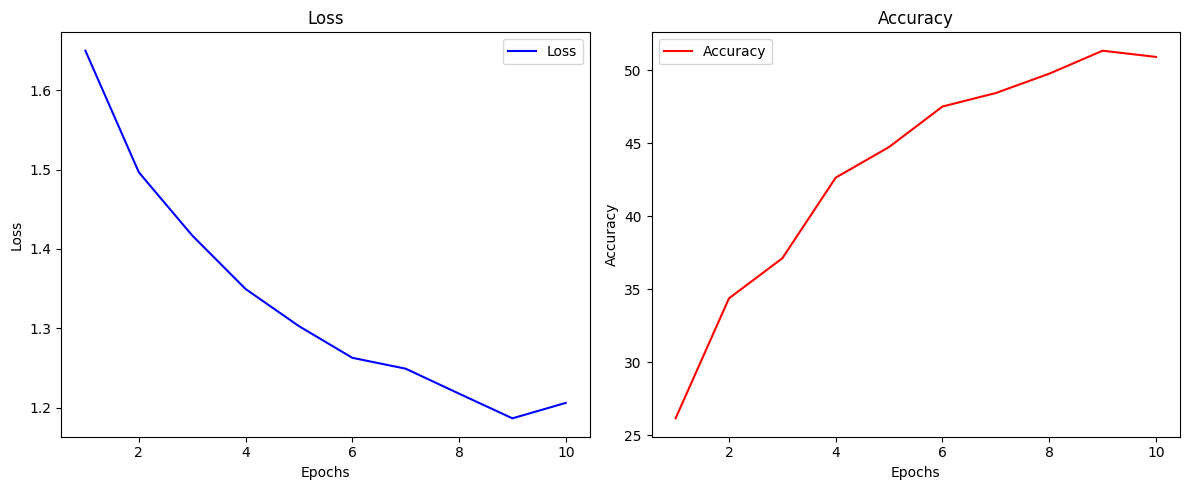

In [15]:
plot_data(loss, accuracy)

In [18]:
validate(fcModel, testloader, device)

Accuracy: 43.40 %
Precision: 0.49
Recall: 0.44
Confusion Matrix:
[[ 30  65  91  14   0]
 [ 18 111  66   4   2]
 [  7  28 144   6   2]
 [ 41  10  14 136   1]
 [ 27  24 100  46  13]]


In [19]:
class ImporvedFC(nn.Module):
    def __init__(self):
        super().__init__()
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(3 * 100 * 100, 1000)
        self.bn1 = nn.BatchNorm1d(1000)
        self.fc2 = nn.Linear(1000, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 5)
        self.dropout = nn.Dropout(0.5)
        self.l_relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.flat(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.l_relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.l_relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [20]:
improvedFcModel = ImporvedFC()
optimizer = optim.Adam(improvedFcModel.parameters())
(loss, accuracy) = train(improvedFcModel, trainloader, criterion, optimizer, epoch, device)

Epoch 1/10: 100%|██████████| 125/125 [00:26<00:00,  4.69it/s]


Epoch 1, Train Loss: 1.4081, Accuracy: 39.48%


Epoch 2/10: 100%|██████████| 125/125 [00:26<00:00,  4.63it/s]


Epoch 2, Train Loss: 1.2742, Accuracy: 46.90%


Epoch 3/10: 100%|██████████| 125/125 [00:27<00:00,  4.57it/s]


Epoch 3, Train Loss: 1.2119, Accuracy: 50.42%


Epoch 4/10: 100%|██████████| 125/125 [00:27<00:00,  4.49it/s]


Epoch 4, Train Loss: 1.1465, Accuracy: 52.92%


Epoch 5/10: 100%|██████████| 125/125 [00:27<00:00,  4.61it/s]


Epoch 5, Train Loss: 1.0874, Accuracy: 55.75%


Epoch 6/10: 100%|██████████| 125/125 [00:27<00:00,  4.61it/s]


Epoch 6, Train Loss: 1.0665, Accuracy: 57.77%


Epoch 7/10: 100%|██████████| 125/125 [00:27<00:00,  4.57it/s]


Epoch 7, Train Loss: 0.9994, Accuracy: 59.98%


Epoch 8/10: 100%|██████████| 125/125 [00:27<00:00,  4.53it/s]


Epoch 8, Train Loss: 0.9694, Accuracy: 61.90%


Epoch 9/10: 100%|██████████| 125/125 [00:27<00:00,  4.53it/s]


Epoch 9, Train Loss: 0.9307, Accuracy: 63.60%


Epoch 10/10: 100%|██████████| 125/125 [00:27<00:00,  4.54it/s]

Epoch 10, Train Loss: 0.8912, Accuracy: 66.10%


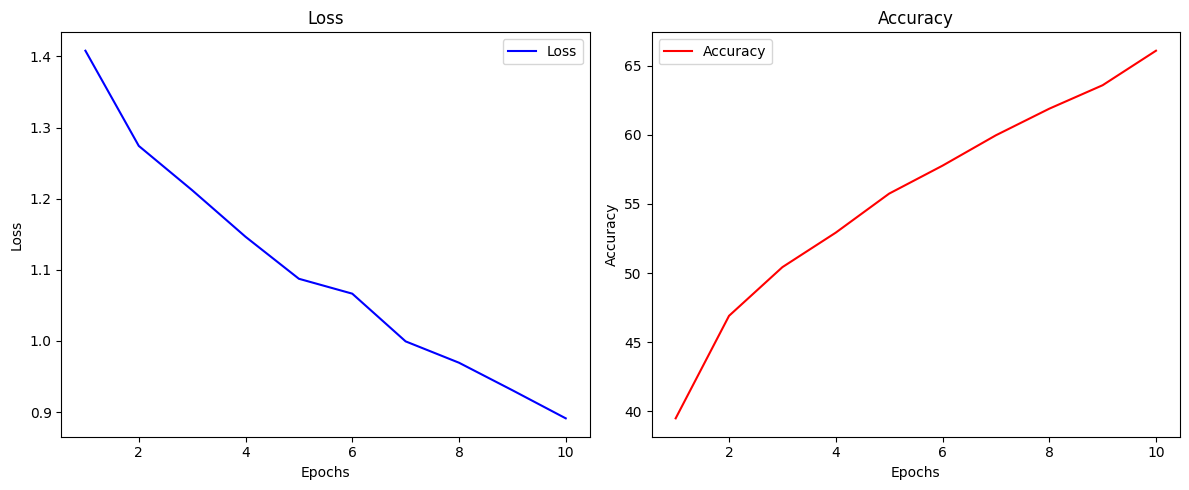

In [21]:
plot_data(loss, accuracy)

In [22]:
validate(improvedFcModel, testloader, device)

Accuracy: 52.90 %
Precision: 0.63
Recall: 0.53
Confusion Matrix:
[[ 48 123   7   1  21]
 [  6 181   6   0   8]
 [ 10 109  51   3  14]
 [  7  25   0 144  26]
 [ 15  69   3  18 105]]
